### Part 1: Basic, no geography tree

In [1]:
# imports
import pandas as pd
from sklearn.metrics import f1_score


In [2]:
# getting the data
data_ng = pd.read_csv(r"C:\Users\Evan\Desktop\_data\prepro_data.csv")
# can be modified as needed

In [3]:
type(data_ng)

pandas.core.frame.DataFrame

In [4]:
data_ng.head()

,case_month,state_fips_code,county_fips_code,age_group,sex,race,case_onset_interval,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,case_positive_specimen,underlying_conditions_yn
0,2020-10,49,49035.0,2,1,5,0,1,1,1,0,0,0,0,1
1,2021-01,49,49057.0,1,1,5,0,1,1,1,0,0,0,0,1
2,2021-02,22,22009.0,2,1,5,0,1,0,1,0,-1,-2,0,1
3,2020-11,42,42025.0,1,1,5,0,1,1,1,0,0,-3,0,1
4,2020-07,42,42003.0,1,1,2,0,1,1,1,0,0,0,1,1


In [5]:
# for preliminary reasons, I will drop date, county/area info, and icu/death info
data_ng.drop(['case_month','state_fips_code','county_fips_code','icu_yn','death_yn'], axis = 1, inplace = True)

In [6]:
data_ng.head()

,age_group,sex,race,case_onset_interval,exposure_yn,current_status,symptom_status,hosp_yn,case_positive_specimen,underlying_conditions_yn
0,2,1,5,0,1,1,1,0,0,1
1,1,1,5,0,1,1,1,0,0,1
2,2,1,5,0,1,0,1,0,0,1
3,1,1,5,0,1,1,1,0,0,1
4,1,1,2,0,1,1,1,0,1,1


In [7]:
data_ng.shape

(123111, 10)

In [8]:
# dropping unkown and missing hosp data - where hosp = -1 or -2
data_ng.drop(data_ng[(data_ng['hosp_yn'] == -1) | (data_ng['hosp_yn'] == -2)].index, inplace = True)

In [9]:
data_ng.shape

(113754, 10)

In [10]:
# now that all of hosp_yn is 1 or 0, I will do a prelim. tree model 
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# select X data
X = np.array( data_ng.drop(['hosp_yn'],axis = 1, inplace = False) )
y = np.array (data_ng['hosp_yn'] )

# for later use in sub-sampling
Xu = np.array( data_ng.drop(['hosp_yn'],axis = 1, inplace = False) )
yu = np.array (data_ng['hosp_yn'] )

In [11]:
# now split the data 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = .2,random_state = 1)

In [12]:
# now build the tree model
from sklearn import tree
dtree = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 2)
dtree = dtree.fit(X_train, y_train)
print("classifier accuracy:",dtree.score(X_test,y_test))

classifier accuracy: 0.9138499406619489


In [13]:
# some count testing - see what percentage of patients in remaining data are hospitilized - about %8.5
print(len(y))
np.count_nonzero(y)

print(np.count_nonzero(y)/len(y))

113754
0.08535963570511806


[Text(0.5, 0.8333333333333334, 'X[0] <= 2.5\ngini = 0.151\nsamples = 22750\nvalue = [20880, 1870]'),
 Text(0.25, 0.5, 'X[0] <= 1.5\ngini = 0.091\nsamples = 17811\nvalue = [16961, 850]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.062\nsamples = 12048\nvalue = [11660, 388]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.147\nsamples = 5763\nvalue = [5301, 462]'),
 Text(0.75, 0.5, 'X[5] <= 0.5\ngini = 0.328\nsamples = 4939\nvalue = [3919, 1020]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.18\nsamples = 821\nvalue = [739, 82]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.352\nsamples = 4118\nvalue = [3180, 938]')]

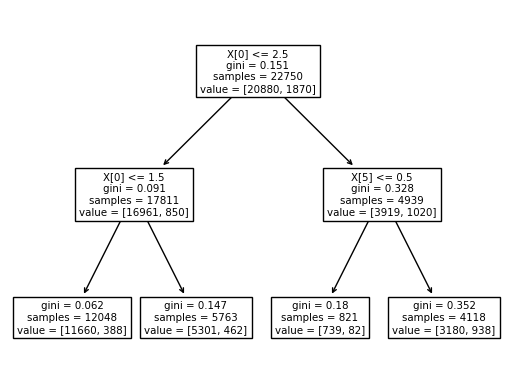

In [14]:
# view the tree
tree.plot_tree(dtree)

# Part 2: Basic, no geo Random Forest


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10, random_state=42)
forest_clf.fit(X_train, y_train)

y_pred = forest_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9138499406619489


In [16]:
print( np.unique( y_pred ) )
# so we can see that there is some error in using this data set as-is,
# the imbalance causes the prediction to always predict 0

[0]


# Part 3: Basic Feature Selection

### Part 3.1: Feature viewing

In [17]:
# feature importance
from matplotlib import pyplot as plt
forest_clf.feature_importances_

array([0.76186203, 0.02945614, 0.02862214, 0.01654309, 0.01479004,
       0.09241745, 0.        , 0.04349937, 0.01280973])

<BarContainer object of 9 artists>

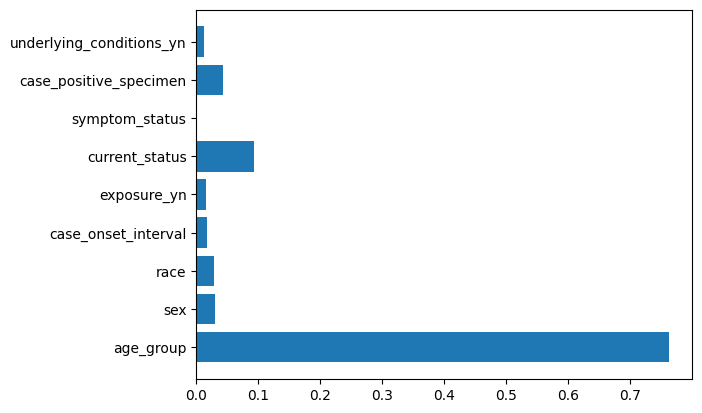

In [18]:
# visualize the attribute importances

cols = np.array(list(data_ng.columns))
# plt.barh(cols,np.array(forest_clf.feature_importances_))
cols = np.delete(cols,7)

plt.barh(cols,np.array(forest_clf.feature_importances_))

In [19]:
# testing what happens if we only keep the top 4 attributes
# drop sex, case_onset_interval, exposure_yn, symptom status, underlying conditions
data_ng2 = data_ng.drop(['sex','case_onset_interval','exposure_yn','symptom_status','underlying_conditions_yn'],
                        axis = 1, inplace = False)

data_ng2.head()

,age_group,race,current_status,hosp_yn,case_positive_specimen
0,2,5,1,0,0
1,1,5,1,0,0
2,2,5,0,0,0
3,1,5,1,0,0
4,1,2,1,0,1


classifier accuracy: 0.9138499406619489


[Text(0.5, 0.75, 'X[0] <= 2.5\ngini = 0.151\nsamples = 22750\nvalue = [20880, 1870]'),
 Text(0.25, 0.25, 'gini = 0.091\nsamples = 17811\nvalue = [16961, 850]'),
 Text(0.75, 0.25, 'gini = 0.328\nsamples = 4939\nvalue = [3919, 1020]')]

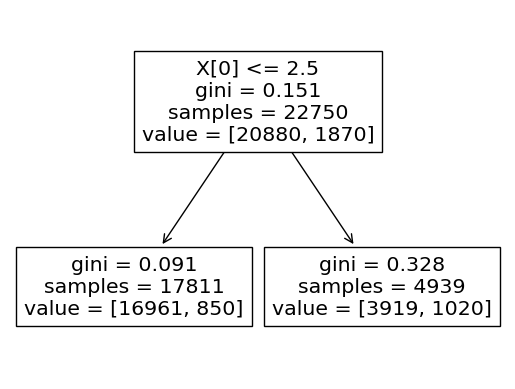

In [20]:
# now retest the tree
# select X data
X = np.array( data_ng2.drop(['hosp_yn'],axis = 1, inplace = False) )
# X = np.array(data_ng2['age_group'])
y = np.array(data_ng2['hosp_yn'] )
# now split the data 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = .2,random_state = 1)
dtree = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 1)
dtree = dtree.fit(X_train, y_train)
print("classifier accuracy:",dtree.score(X_test,y_test))
tree.plot_tree(dtree)

# Part 4: Sub-Sampling testing

In [21]:
# We can see that the split between the hospitalization rates is causing some bad behavior in the model
# so let's try some sampling
data_ng.shape

(113754, 10)

In [22]:
# misc. testing
data_hosp = data_ng.drop(data_ng[data_ng['hosp_yn'] == 0].index, inplace = False)
data_hosp.shape

(9710, 10)

In [23]:
print(X.shape)
print(y.shape)

(113754, 4)
(113754,)


#### Part 4.1: Undersampling

In [24]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=420, replacement=True)
X_rus, y_rus = rus.fit_resample(X,y)

# X_rus, y_rus = rus.fit_resample(Xu,yu)

print(X_rus.shape)
print(y_rus.shape)

# just attempt a tree with this 
# now split the data 
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus,y_rus,train_size = .2,random_state = 1)

dtree = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 1)
dtree = dtree.fit(X_train_rus, y_train_rus)
print("classifier accuracy:",dtree.score(X_test_rus,y_test_rus))

(19420, 4)
(19420,)
classifier accuracy: 0.670764675592173


[Text(0.5, 0.75, 'X[0] <= 2.5\ngini = 0.5\nsamples = 3884\nvalue = [2003, 1881]'),
 Text(0.25, 0.25, 'gini = 0.451\nsamples = 2512\nvalue = [1649, 863]'),
 Text(0.75, 0.25, 'gini = 0.383\nsamples = 1372\nvalue = [354, 1018]')]

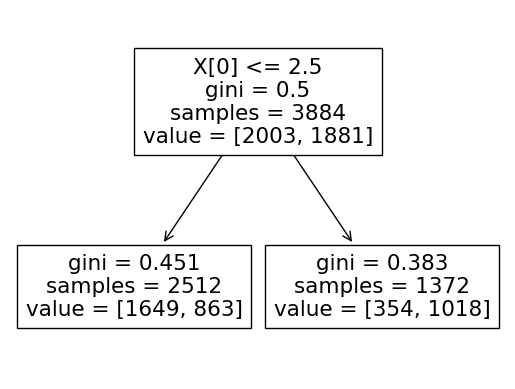

In [25]:
tree.plot_tree(dtree)

In [26]:
# random Forest with this data
forest_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10, random_state=42)
forest_clf.fit(X_train_rus, y_train_rus)

y_pred = forest_clf.predict(X_test_rus)
print(accuracy_score(y_test_rus, y_pred))

0.6866632337796087


#### Part 4.2: Oversampling

In [27]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X,y)

print(X_ros.shape)
print(y_ros.shape)

# just attempt a tree with this 
# now split the data 
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros,y_ros,train_size = .2,random_state = 1)

dtree = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 1)
dtree = dtree.fit(X_train_ros, y_train_ros)
print("classifier accuracy:",dtree.score(X_test_ros,y_test_ros))

(208088, 4)
(208088,)
classifier accuracy: 0.6747481543331871


[Text(0.5, 0.75, 'X[0] <= 2.5\ngini = 0.5\nsamples = 41617\nvalue = [20898, 20719]'),
 Text(0.25, 0.25, 'gini = 0.461\nsamples = 26542\nvalue = [16962, 9580]'),
 Text(0.75, 0.25, 'gini = 0.386\nsamples = 15075\nvalue = [3936, 11139]')]

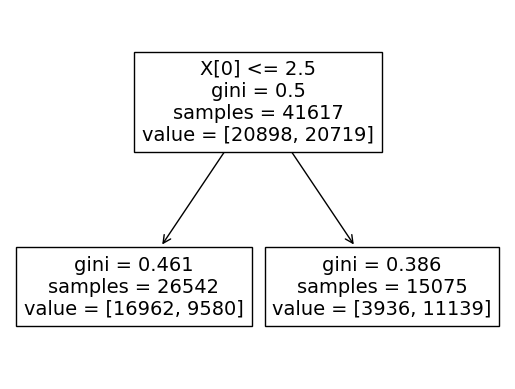

In [28]:
tree.plot_tree(dtree)

In [29]:
# random Forest with this data
forest_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=10, random_state=42)
forest_clf.fit(X_train_ros, y_train_ros)

y_pred = forest_clf.predict(X_test_ros)
print(accuracy_score(y_test_ros, y_pred))

0.6923007610935238


So it seems subsampling does not help the model find a better fit, I think this may be attributed to the fact 
that the tree not only has a dominating class, but within that class there is a dominating attribute, as well, and I am unsure if the over/under sampling picked up on the dominance of age group.
This may lead to some interesting behavior; interesting but perhaps not good for our case. 

I think with the nature of our data that a probability based approach may be better: outputting the probability of hospitilization may prove more useful and attainable:

EX: What is the probability of hospitilization given the spread of attributes, then move that towards including geographical data

# Part 5: NBC (Maybe)

# Part X: Some Data Investigation:

In [30]:
# preview the data
data_ng.head()

# drop everything except the two most powerfull attributes: age_group and current status
X_vis = np.array( data_ng.drop(['hosp_yn','sex','race','case_onset_interval','exposure_yn',
                               'symptom_status','underlying_conditions_yn','current_status'],axis = 1, inplace = False) )
y_vis = np.array (data_ng['hosp_yn'] )

In [31]:
# split data into hosp and not
hosp = X_vis[np.where(y_vis == 1)]
no_hosp = X_vis[np.where(y_vis == 0)]

In [32]:
hosp

array([[0, 0],
       [3, 0],
       [3, 0],
       ...,
       [1, 1],
       [3, 1],
       [3, 2]], dtype=int64)

In [33]:
hosp[:,0].size

9710

In [34]:
age_zero = np.count_nonzero(hosp[:,0] == 0)
print(age_zero)
print(age_zero/hosp[:,0].size)
age_1 = np.count_nonzero(hosp[:,0] == 1)
print(age_1)
print(age_1/hosp[:,0].size)
age_2 = np.count_nonzero(hosp[:,0] == 2)
print(age_2)
print(age_2/hosp[:,0].size)
age_3 = np.count_nonzero(hosp[:,0] == 3)
print(age_3)
print(age_3/hosp[:,0].size)

122
0.012564366632337795
1902
0.19588053553038104
2488
0.25623069001029863
5198
0.5353244078269825


In [35]:
age_zero = np.count_nonzero(no_hosp[:,1] == 0)
print(age_zero)
print(age_zero/no_hosp[:,1].size)
age_1 = np.count_nonzero(no_hosp[:,1] == 1)
print(age_1)
print(age_1/no_hosp[:,1].size)
age_2 = np.count_nonzero(no_hosp[:,1] == 2)
print(age_2)
print(age_2/no_hosp[:,1].size)
age_3 = np.count_nonzero(no_hosp[:,1] == 3)
print(age_3)
print(age_3/no_hosp[:,1].size)

75808
0.7286148168082734
24480
0.23528507170043444
2028
0.01949175348890854
347
0.0033351274460805044


In [36]:
X_rus2 = np.delete(X_rus, [1,2,3],1)
# print(X_rus2)
# print(y_rus)
hosp = X_rus2[np.where(y_rus == 1)]
no_hosp = X_rus2[np.where(y_rus == 0)]

In [37]:
print(hosp.shape)
print(no_hosp.shape)

(9710, 1)
(9710, 1)


In [38]:
age_zero = np.count_nonzero(hosp[:,0] == 0)
print(age_zero)
print(age_zero/hosp[:,0].size)
age_1 = np.count_nonzero(hosp[:,0] == 1)
print(age_1)
print(age_1/hosp[:,0].size)
age_2 = np.count_nonzero(hosp[:,0] == 2)
print(age_2)
print(age_2/hosp[:,0].size)
age_3 = np.count_nonzero(hosp[:,0] == 3)
print(age_3)
print(age_3/hosp[:,0].size)

122
0.012564366632337795
1902
0.19588053553038104
2488
0.25623069001029863
5198
0.5353244078269825


In [39]:
age_zero = np.count_nonzero(no_hosp[:,0] == 0)
print(age_zero)
print(age_zero/no_hosp[:,0].size)
age_1 = np.count_nonzero(no_hosp[:,0] == 1)
print(age_1)
print(age_1/no_hosp[:,0].size)
age_2 = np.count_nonzero(no_hosp[:,0] == 2)
print(age_2)
print(age_2/no_hosp[:,0].size)
age_3 = np.count_nonzero(no_hosp[:,0] == 3)
print(age_3)
print(age_3/no_hosp[:,0].size)

789
0.08125643666323377
4635
0.47734294541709577
2466
0.2539649845520082
1820
0.1874356333676622


We can see the differences in distribution of the age groups that the random undersampling did not have the same age distribution in percentages as in the real data.